In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gonzalomajlis
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [03:52<00:00, 24.0MB/s]


In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
# Cargar el CSV con las etiquetas
df = pd.read_csv('/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
images_ids = df['image_id'].values
dxs = df['dx'].values

img_dir1 = '/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
img_dir2 = '/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
img_dirs = [img_dir1, img_dir2]

In [ ]:
print(len(np.unique(dxs)))
print(np.unique(dxs))

7
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [ ]:
enfermedades = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(dxs)
y_categorical = to_categorical(y_encoded, num_classes=7)

In [ ]:
print('imagen: ' + images_ids[0] + ' enfermedad: ' + str(y_categorical[0]))

imagen: ISIC_0027419 enfermedad: [0. 0. 1. 0. 0. 0. 0.]


In [ ]:
print(y_categorical.shape)

(10015, 7)


In [ ]:
X_train_filenames, X_val_test, y_train, y_val_test = train_test_split(images_ids, y_categorical, test_size=0.2, random_state=42)

In [ ]:
X_val_filenames, X_test_filenames, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.7, random_state=42)

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Crear un generador personalizado que hereda de Sequence
class MultiDirectoryDataGenerator(Sequence):
    def __init__(self, filenames, labels, img_dirs, batch_size=32, target_size=(224, 224), shuffle=True, **kwargs):
        self.filenames = filenames
        self.labels = labels
        self.img_dirs = img_dirs
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

        super().__init__(**kwargs)

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        # Índices para el batch actual
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Inicializar arrays para el batch
        batch_x = []
        batch_y = []

        # Cargar imágenes del batch actual
        for i in batch_indexes:
            filename = self.filenames[i]
            label = self.labels[i]

            # Buscar en múltiples directorios
            img_loaded = False
            for img_dir in self.img_dirs:
                img_path = os.path.join(img_dir, filename + '.jpg')
                if os.path.exists(img_path):
                    img = load_img(img_path, target_size=self.target_size)
                    img = img_to_array(img)
                    img = img / 255.0
                    batch_x.append(img)
                    batch_y.append(label)
                    img_loaded = True
                    break

            if not img_loaded:
                print(f"No se encontró la imagen: {filename}")

        return np.array(batch_x, dtype=np.float32), np.array(batch_y, dtype=np.float32)

    def on_epoch_end(self):
        # Mezclar los índices después de cada época
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [ ]:
def load_images_from_multiple_dirs(filenames, img_dirs, target_size=(224, 224)):
    images = []
    for filename in filenames:
        img_loaded = False
        # Intentar cargar desde cada directorio
        for img_dir in img_dirs:
            img_path = os.path.join(img_dir, filename + '.jpg')
            if os.path.exists(img_path):
                img = load_img(img_path, target_size=target_size)
                img = img_to_array(img)
                img = img / 255.0
                images.append(img)
                img_loaded = True
                break

        if not img_loaded:
            print(f"No se encontró la imagen: {filename}")
            # Puedes decidir qué hacer aquí: omitir, usar una imagen en blanco, etc.

    return np.array(images)

In [ ]:
print(f'Tamaño de X_train: {len(X_train_filenames)}')
print(f'Tamaño de X_val: {len(X_val_filenames)}')
print(f'Tamaño de X_test: {len(X_test_filenames)}')

Tamaño de X_train: 8012
Tamaño de X_val: 600
Tamaño de X_test: 1403


In [ ]:
# Crear los generadores de datos
train_generator = MultiDirectoryDataGenerator(
    X_train_filenames, y_train, img_dirs, batch_size=32,
    target_size=(224, 224), shuffle=True
)

val_generator = MultiDirectoryDataGenerator(
    X_val_filenames, y_val, img_dirs, batch_size=32,
    target_size=(224, 224), shuffle=False
)

#test_generator = MultiDirectoryDataGenerator(
#    X_test_filenames, y_test, img_dirs, batch_size=32,
#    target_size=(224, 224), shuffle=False
#)
X_test = load_images_from_multiple_dirs(X_test_filenames, [img_dir1, img_dir2])

In [ ]:
print(f'Tamaño de X_train: {len(X_train_filenames)}')
print(f'Tamaño de X_val: {len(X_val_filenames)}')
print(f'Tamaño de X_test: {len(X_test_filenames)}')

Tamaño de X_train: 8012
Tamaño de X_val: 600
Tamaño de X_test: 1403


In [ ]:
#X_train_filenames[0].shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import matplotlib.pyplot as plt

MobileNet

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
base_model_mobilenet = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

In [ ]:
base_model_mobilenet.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = base_model_mobilenet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = layers.Dense(7, activation='softmax')(x)

In [ ]:
modelMobileNet = Model(inputs, outputs)

In [ ]:
modelMobileNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
historyMobileNet = modelMobileNet.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 255ms/step - accuracy: 0.6969 - loss: 0.9326 - val_accuracy: 0.7583 - val_loss: 0.6889
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 62s 245ms/step - accuracy: 0.7765 - loss: 0.6256 - val_accuracy: 0.7650 - val_loss: 0.6602
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 59s 236ms/step - accuracy: 0.7862 - loss: 0.5667 - val_accuracy: 0.7667 - val_loss: 0.6499
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 62s 248ms/step - accuracy: 0.8194 - loss: 0.4926 - val_accuracy: 0.7817 - val_loss: 0.6379
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 59s 235ms/step - accuracy: 0.8356 - loss: 0.4584 - val_accuracy: 0.7683 - val_loss: 0.6536
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 61s 242ms/step - accuracy: 0.8580 - loss: 0.3988 - val_accuracy: 0.7750 - val_loss: 0.6508
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 60s 237ms/step - accuracy: 0.8696 - loss: 0.3559 - val_accuracy: 0.7800 - val_loss: 0.6452
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 62s 249ms/step - accuracy: 0.8899 - loss: 0.3001 - val

In [ ]:
preds_mobilenet = modelMobileNet.evaluate(X_test, y_test)
print('loss = ' + str(preds_mobilenet[0]))
print('accuracy = ' + str(preds_mobilenet[1]))

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7619 - loss: 0.7352
loss = 0.6765092611312866
accuracy = 0.7890235185623169


ResNet

In [ ]:
base_model_resnet = ResNet50V2(input_shape=input_shape, include_top=False, weights='imagenet')

In [ ]:
base_model_resnet.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = base_model_resnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = layers.Dense(7, activation='softmax')(x)

In [ ]:
modelResNet = Model(inputs, outputs)

In [ ]:
modelResNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
historyResNet = modelResNet.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 115s 299ms/step - accuracy: 0.6365 - loss: 1.1329 - val_accuracy: 0.7400 - val_loss: 0.7562
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 64s 254ms/step - accuracy: 0.7432 - loss: 0.7380 - val_accuracy: 0.7550 - val_loss: 0.7077
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 65s 257ms/step - accuracy: 0.7620 - loss: 0.6585 - val_accuracy: 0.7617 - val_loss: 0.6827
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 66s 263ms/step - accuracy: 0.7989 - loss: 0.5666 - val_accuracy: 0.7600 - val_loss: 0.6713
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 64s 256ms/step - accuracy: 0.8172 - loss: 0.5245 - val_accuracy: 0.7717 - val_loss: 0.6553
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 64s 256ms/step - accuracy: 0.8345 - loss: 0.4735 - val_accuracy: 0.7800 - val_loss: 0.6437
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 265ms/step - accuracy: 0.8433 - loss: 0.4611 - val_accuracy: 0.7700 - val_loss: 0.6355
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 64s 256ms/step - accuracy: 0.8625 - loss: 

In [ ]:
preds_resnet = modelResNet.evaluate(X_test, y_test)
print('loss = ' + str(preds_resnet[0]))
print('accuracy = ' + str(preds_resnet[1]))

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.7678 - loss: 0.6607
loss = 0.6531354188919067
accuracy = 0.7676407694816589


Manual Testing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img

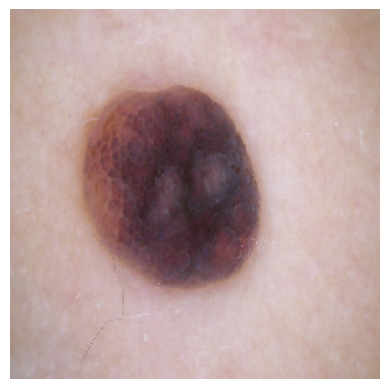

In [ ]:
plt.imshow(X_test[0])
plt.axis('off')
plt.show()

In [ ]:
img = X_test[0]
img_resized = np.array(array_to_img(img).resize((224, 224)))
mobile_test = modelMobileNet.predict(np.expand_dims(img_resized, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
enf = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
print("Valor de argmax:", np.argmax(mobile_test))

Valor de argmax: 5


In [ ]:
print(f'prediccion: {enf[np.argmax(mobile_test)]}')
print(f'real: {enf[np.argmax(y_test[0])]}')

prediccion: nv
real: nv


In [ ]:
resnet_test = modelResNet.predict(np.expand_dims(img_resized, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
print(f'prediccion: {enf[np.argmax(resnet_test)]}')
print(f'real: {enf[np.argmax(y_test[0])]}')

prediccion: nv
real: nv
